# UK General Election Modelling

## What is Psephology?

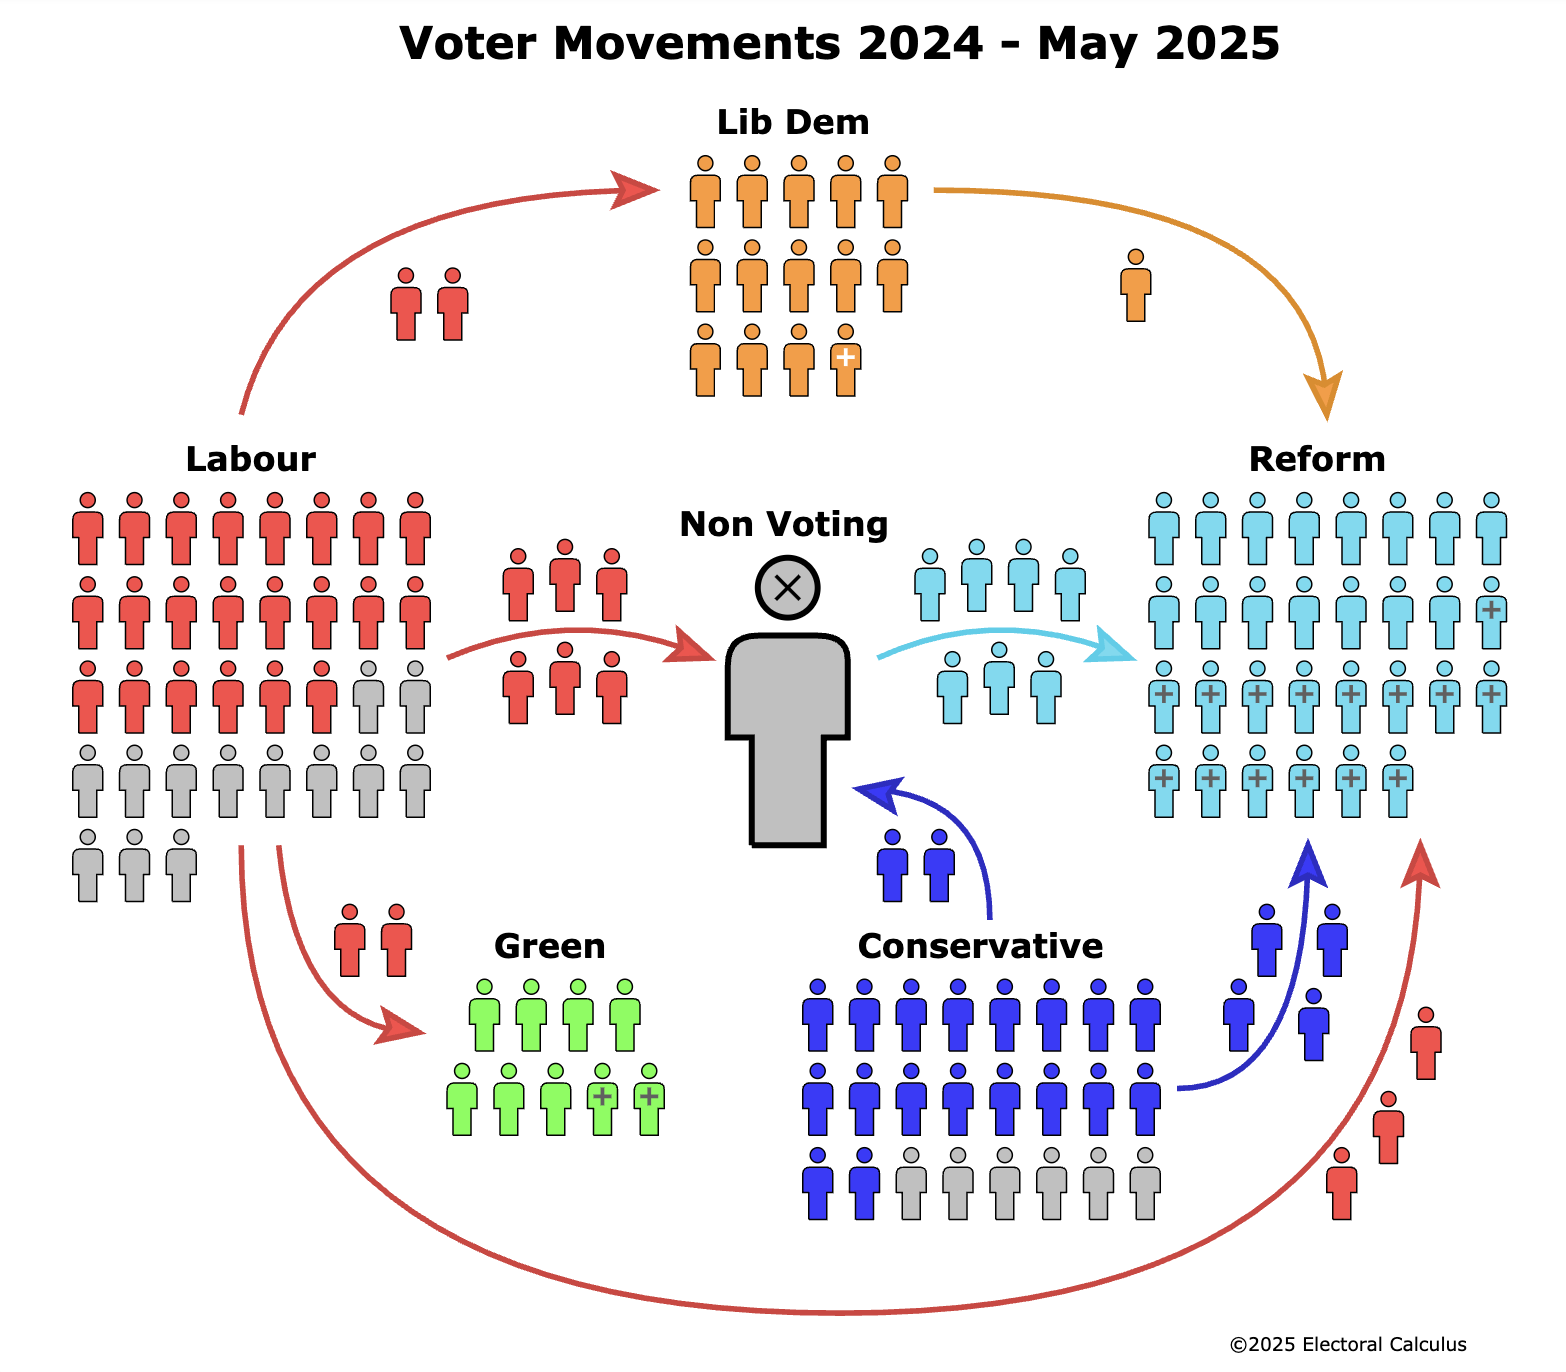


The swing from party A to party B between two elections (e.g. 2019 and 2024) can be written as:

Let 
$
*s_{A}^{(2019)} \quad\text{and}\quad s_{B}^{(2019)}*
$
be the vote‐share percentages (in %) for parties A and B in 2019, and
$
s_{A}^{(2024)} \quad\text{and}\quad s_{B}^{(2024)}
$
be the vote‐share percentages in 2024. Then the one‐dimensional swing from A to B is

$$
\text{Swing}_{\,A \to B}
\;=\;
\frac{1}{2}\Bigl[\bigl(s_{B}^{(2024)} - s_{B}^{(2019)}\bigr)\;-\;\bigl(s_{A}^{(2024)} - s_{A}^{(2019)}\bigr)\Bigr].
$$

In words, this measures the net movement of vote share from A into B (or vice versa). A positive value means a swing from A towards B; a negative value means a swing from B towards A.


In [13]:
%pip install -q geopandas folium openpyxl


Note: you may need to restart the kernel to use updated packages.


In [1]:
import geopandas as gpd

# 1a. Load the original GeoJSON (high‐res boundaries)
gdf = gpd.read_file("constituencies.geojson")

# 1b. Reproject to a metric CRS for more consistent simplification (EPSG:3857 is fine)
gdf = gdf.to_crs(epsg=3857)

# 1c. Simplify with a tolerance (in metres). 
#     You can tweak “500” up or down: 
#     - larger → more aggressive simplification (smaller file, less detail)
#     - smaller → more detail (larger file)
gdf["geometry"] = gdf.geometry.simplify(tolerance=500, preserve_topology=True)

# 1d. (Optional) Re‐project back to WGS84 for Folium
gdf = gdf.to_crs(epsg=4326)

# 1e. Save the simplified version (so you don’t re‐run simplification every time)
gdf.to_file("constituencies_simplified.geojson", driver="GeoJSON")


In [5]:
import geopandas as gpd
import pandas as pd
import folium

# === Step 1: Load spatial GeoJSON with 2024 constituency polygons ===
gdf = gpd.read_file("constituencies_simplified.geojson")  # must contain 'geometry' and 'PCON24CD'

# === Step 2: Load 2024 & 2019 election results CSVs ===
results_2024 = pd.read_csv("HoC-GE2024-results-by-constituency.csv")
results_2019 = pd.read_csv("HoC-GE2019-results-by-constituency.csv")

# === Step 3: Merge 2024 results onto GeoDataFrame ===
# Join on 2024 code 'PCON24CD' == results_2024['ONS ID']
merged_2024 = gdf.merge(
    results_2024,
    left_on="PCON24CD",
    right_on="ONS ID",
    how="left"
)

# === Step 4: Merge 2019 results onto the same GeoDataFrame ===
# (Again join on PCON24CD == results_2019['ONS ID']; 
#  any seats that did not exist in 2019 will have NaN for 2019 fields.)
merged_both = merged_2024.merge(
    results_2019,
    left_on="PCON24CD",
    right_on="ONS ID",
    how="left",
    suffixes=("_2024", "_2019")
)

# === Step 5: Define party colours ===
party_colors = {
    "Con":   "#0087DC",   # Conservative
    "Lab":   "#DC241f",   # Labour
    "LD":    "#FDBB30",   # Lib Dem
    "SNP":   "#FFF95D",
    "Green": "#6AB023",
    "PC":    "#FFD100",
    "DUP":   "#F4D759",
    "SF":    "#326760",
    "SDLP":  "#367B25",
    "APNI":  "#99D9EA",
    "UUP":   "#00A5DE",
    "TUV":   "#EE1C25",
    "RUK":   "#00B2A9",   # Reform UK
    "BRX":   "#00B2A9",   # Brexit Party in 2019, reuse Reform UK colour
    "Ind":   "#AAAAAA",
    "Spk":   "#000000"
}
default_color = "#FFFFFF"  # fallback if no party

# === Step 6: Create Folium map with a white background ===
m = folium.Map(location=[55.3781, -3.4360], zoom_start=5, tiles=None)

# Add a white tile layer so the map background is plain white
folium.TileLayer(
    tiles="https://tiles.wmflabs.org/bw-mapnik/{z}/{x}/{y}.png",
    attr="&copy; Wikimedia",
    name="White background",
    control=False
).add_to(m)

# === Step 7: Add GeoJson layer for 2024 results ===
folium.GeoJson(
    merged_both,
    name="GE2024 Results",
    style_function=lambda feature: {
        "fillColor": party_colors.get(
            feature["properties"].get("First party_2024"), 
            default_color
        ),
        "color": "black",
        "weight": 0.5,
        "fillOpacity": 0.85
    },
    tooltip=folium.GeoJsonTooltip(
        fields=[
            "PCON24NM",              # constituency name from GeoJSON
            "First party_2024",      
            "Member first name_2024",
            "Member surname_2024",
            "Majority_2024"
        ],
        aliases=[
            "Constituency:",
            "2024 Winning party:",
            "2024 MP first name:",
            "2024 MP surname:",
            "2024 Majority:"
        ],
        localize=True
    )
).add_to(m)

# === Step 8: Add GeoJson layer for 2019 results ===
folium.GeoJson(
    merged_both,
    name="GE2019 Results",
    style_function=lambda feature: {
        "fillColor": party_colors.get(
            feature["properties"].get("First party_2019"), 
            default_color
        ),
        "color": "black",
        "weight": 0.5,
        "fillOpacity": 0.85
    },
    tooltip=folium.GeoJsonTooltip(
        fields=[
            "PCON24NM",              # constituency name from GeoJSON
            "First party_2019",
            "Member first name_2019",
            "Member surname_2019",
            "Majority_2019"
        ],
        aliases=[
            "Constituency:",
            "2019 Winning party:",
            "2019 MP first name:",
            "2019 MP surname:",
            "2019 Majority:"
        ],
        localize=True
    )
).add_to(m)

# === Step 9: Add common party‐colour legend HTML (bottom-left by default) ===
legend_html = """
<div style="
    position: fixed; 
    bottom: 30px; left: 30px; width: 220px; 
    z-index: 9999; font-size: 14px;
    background-color: white; 
    border: 2px solid grey; 
    border-radius: 5px;
    padding: 10px;">
  <b>Party Colours</b><br>
  <i style='background:#0087DC;width:12px;height:12px;
      display:inline-block;margin-right:6px;'></i> Conservative<br>
  <i style='background:#DC241f;width:12px;height:12px;
      display:inline-block;margin-right:6px;'></i> Labour<br>
  <i style='background:#FDBB30;width:12px;height:12px;
      display:inline-block;margin-right:6px;'></i> Liberal Democrat<br>
  <i style='background:#FFF95D;width:12px;height:12px;
      display:inline-block;margin-right:6px;'></i> SNP<br>
  <i style='background:#6AB023;width:12px;height:12px;
      display:inline-block;margin-right:6px;'></i> Green<br>
  <i style='background:#FFD100;width:12px;height:12px;
      display:inline-block;margin-right:6px;'></i> Plaid Cymru<br>
  <i style='background:#F4D759;width:12px;height:12px;
      display:inline-block;margin-right:6px;'></i> DUP<br>
  <i style='background:#326760;width:12px;height:12px;
      display:inline-block;margin-right:6px;'></i> Sinn Féin<br>
  <i style='background:#00B2A9;width:12px;height:12px;
      display:inline-block;margin-right:6px;'></i> Reform UK (or Brexit)<br>
  <i style='background:#AAAAAA;width:12px;height:12px;
      display:inline-block;margin-right:6px;'></i> Independent<br>
</div>
"""
m.get_root().html.add_child(folium.Element(legend_html))

# === Step 10: Add LayerControl (to toggle 2024 vs 2019) ===
folium.LayerControl(position="topright").add_to(m)

# === Step 11: Save map ===
m.save("uk_2019_2024_layers.html")
print("Map saved: uk_2019_2024_layers.html")


Map saved: uk_2019_2024_layers.html


In [6]:
import geopandas as gpd
import pandas as pd
import folium
import difflib

# ─────────────────────────────────────────────────────────────────────────────
# 1) Load 2024 boundary GeoJSON (simplified)
gdf_2024 = gpd.read_file("constituencies_simplified.geojson")
# Ensure “PCON24CD” and “PCON24NM” exist:
if "PCON24CD" not in gdf_2024.columns or "PCON24NM" not in gdf_2024.columns:
    raise RuntimeError("GeoJSON must have ‘PCON24CD’ and ‘PCON24NM’ columns.")

# ─────────────────────────────────────────────────────────────────────────────
# 2) Load your final 650-row mapping
mapping = pd.read_csv("constituency_closest_successors_final.csv", dtype=str)
# It must have columns: ['2019_code','2019_name','2024_code','2024_name']

# ─────────────────────────────────────────────────────────────────────────────
# 3) Load 2019 & 2024 results CSVs, and rename their key columns
results_2019 = pd.read_csv("HoC-GE2019-results-by-constituency.csv", dtype=str)
results_2019 = results_2019.rename(columns={
    "ONS ID":             "ONS_ID_2019",
    "First party":        "First_party_2019",
    "Member first name":  "Member_first_name_2019",
    "Member surname":     "Member_surname_2019",
    "Majority":           "Majority_2019"
})

results_2024 = pd.read_csv("HoC-GE2024-results-by-constituency.csv", dtype=str)
results_2024 = results_2024.rename(columns={
    "ONS ID":             "ONS_ID_2024",
    "First party":        "First_party_2024",
    "Member first name":  "Member_first_name_2024",
    "Member surname":     "Member_surname_2024",
    "Majority":           "Majority_2024"
})

# Build sets for fuzzy fallback
valid_2019_codes = set(results_2019["ONS_ID_2019"])
valid_2019_names = set(results_2019["Constituency name"])
valid_2024_codes = set(results_2024["ONS_ID_2024"])
valid_2024_names = set(gdf_2024["PCON24NM"])

# ─────────────────────────────────────────────────────────────────────────────
# 4) Fuzzy‐match helpers
def fuzzy_match(word, candidates):
    if not isinstance(word, str):
        word = ""
    matches = difflib.get_close_matches(word, candidates, n=1, cutoff=0.5)
    return matches[0] if matches else None

# ─────────────────────────────────────────────────────────────────────────────
# 5) Build a robust lookup table attaching 2019_code→2024_code for all 650 seats
records = []
for _, row in mapping.iterrows():
    c2019 = row["2019_code"]
    n2019 = row["2019_name"]
    c2024 = row["2024_code"]
    n2024 = row["2024_name"]

    # If both codes are valid, use them
    if c2019 in valid_2019_codes and c2024 in valid_2024_codes:
        records.append({
            "PCON24CD":       c2024,
            "PCON24NM":       n2024,
            "use_2019_code":  c2019,
            "use_2019_name":  n2019
        })
        continue

    # Otherwise try fuzzy‐matching names
    best2024 = n2024 if n2024 in valid_2024_names else fuzzy_match(n2024, valid_2024_names)
    best2019 = n2019 if n2019 in valid_2019_names else fuzzy_match(n2019, valid_2019_names)

    code2024 = None
    code2019 = None
    if best2024:
        candidates = gdf_2024.loc[gdf_2024["PCON24NM"] == best2024, "PCON24CD"].values
        code2024 = candidates[0] if candidates.size else None
    if best2019:
        candidates = results_2019.loc[results_2019["Constituency name"] == best2019, "ONS_ID_2019"].values
        code2019 = candidates[0] if candidates.size else None

    records.append({
        "PCON24CD":       code2024,
        "PCON24NM":       best2024,
        "use_2019_code":  code2019,
        "use_2019_name":  best2019
    })

lookup = pd.DataFrame(records)

# Verify all 650 2024 codes are present
if lookup["PCON24CD"].nunique() != 650:
    raise RuntimeError(f"Expected 650 distinct 2024 codes, got {lookup['PCON24CD'].nunique()}")

# ─────────────────────────────────────────────────────────────────────────────
# 6) Merge 2024 Geo → 2024 results → mapping → 2019 results

# 6a) Start by merging gdf_2024 with 2024 results on PCON24CD == ONS_ID_2024
gdf = gdf_2024.merge(
    results_2024,
    left_on="PCON24CD",
    right_on="ONS_ID_2024",
    how="left"
)

# 6b) Merge that with lookup on PCON24CD
gdf = gdf.merge(
    lookup[["PCON24CD", "use_2019_code"]],
    on="PCON24CD",
    how="left"
)

# 6c) Merge with 2019 results on use_2019_code == ONS_ID_2019
gdf = gdf.merge(
    results_2019,
    left_on="use_2019_code",
    right_on="ONS_ID_2019",
    how="left",
    suffixes=("_2024","_2019")
)

# Count any missing 2019 matches
missing_2019 = gdf["use_2019_code"].isna().sum()
if missing_2019 > 0:
    print(f"Warning: {missing_2019} polygons did not match a 2019 result (these will be white).")

# ─────────────────────────────────────────────────────────────────────────────
# 7) Party‐color dictionary
party_colors = {
    "Con":   "#0087DC",
    "Lab":   "#DC241f",
    "LD":    "#FDBB30",
    "SNP":   "#FFF95D",
    "Green": "#6AB023",
    "PC":    "#FFD100",
    "DUP":   "#F4D759",
    "SF":    "#326760",
    "SDLP":  "#367B25",
    "APNI":  "#99D9EA",
    "UUP":   "#00A5DE",
    "TUV":   "#EE1C25",
    "RUK":   "#00B2A9",
    "BRX":   "#00B2A9",
    "Ind":   "#AAAAAA",
    "Spk":   "#000000"
}
default_color = "#FFFFFF"

# ─────────────────────────────────────────────────────────────────────────────
# 8) Build Folium map with two layers: 2019 and 2024

m = folium.Map(location=[55.3781, -3.4360], zoom_start=5, tiles=None)
folium.TileLayer(
    tiles="https://tiles.wmflabs.org/bw-mapnik/{z}/{x}/{y}.png",
    attr="&copy; Wikimedia",
    name="White background",
    control=False
).add_to(m)

# 8a) 2019 layer (mapped onto 2024 boundaries)
folium.GeoJson(
    gdf,
    name="GE2019 on 2024 boundaries",
    style_function=lambda feat: {
        "fillColor": party_colors.get(
            feat["properties"].get("First_party_2019"), default_color
        ),
        "color": "black",
        "weight": 0.3,
        "fillOpacity": 0.85
    },
    tooltip=folium.GeoJsonTooltip(
        fields=[
            "PCON24NM",             # 2024 boundary
            "First_party_2019",     # 2019 winning party
            "Member_first_name_2019",
            "Member_surname_2019",
            "Majority_2019"
        ],
        aliases=[
            "2024 Boundary:",
            "2019 Winning party:",
            "2019 MP first name:",
            "2019 MP surname:",
            "2019 Majority:"
        ],
        localize=True
    )
).add_to(m)

# 8b) 2024 layer
folium.GeoJson(
    gdf,
    name="GE2024 Results",
    style_function=lambda feat: {
        "fillColor": party_colors.get(
            feat["properties"].get("First_party_2024"), default_color
        ),
        "color": "black",
        "weight": 0.3,
        "fillOpacity": 0.85
    },
    tooltip=folium.GeoJsonTooltip(
        fields=[
            "PCON24NM",             # 2024 boundary
            "First_party_2024",     # 2024 winning party
            "Member_first_name_2024",
            "Member_surname_2024",
            "Majority_2024"
        ],
        aliases=[
            "2024 Boundary:",
            "2024 Winning party:",
            "2024 MP first name:",
            "2024 MP surname:",
            "2024 Majority:"
        ],
        localize=True
    )
).add_to(m)

# ─────────────────────────────────────────────────────────────────────────────
# 9) Add combined legend (bottom-left)
legend_html = """
<div style="
    position: fixed;
    bottom: 30px; left: 30px; width: 240px;
    z-index: 9999; font-size: 14px;
    background-color: white;
    border: 2px solid grey;
    border-radius: 5px;
    padding: 10px;">
  <b>Party Colours</b><br>
  <i style='background:#0087DC;width:12px;height:12px;
      display:inline-block;margin-right:6px;'></i> Conservative<br>
  <i style='background:#DC241f;width:12px;height:12px;
      display:inline-block;margin-right:6px;'></i> Labour<br>
  <i style='background:#FDBB30;width:12px;height:12px;
      display:inline-block;margin-right:6px;'></i> Liberal Democrat<br>
  <i style='background:#FFF95D;width:12px;height:12px;
      display:inline-block;margin-right:6px;'></i> SNP<br>
  <i style='background:#6AB023;width:12px;height:12px;
      display:inline-block;margin-right:6px;'></i> Green<br>
  <i style='background:#FFD100;width:12px;height:12px;
      display:inline-block;margin-right:6px;'></i> Plaid Cymru<br>
  <i style='background:#F4D759;width:12px;height:12px;
      display:inline-block;margin-right:6px;'></i> DUP<br>
  <i style='background:#326760;width:12px;height:12px;
      display:inline-block;margin-right:6px;'></i> Sinn Féin<br>
  <i style='background:#00B2A9;width:12px;height:12px;
      display:inline-block;margin-right:6px;'></i> Reform UK / Brexit<br>
  <i style='background:#AAAAAA;width:12px;height:12px;
      display:inline-block;margin-right:6px;'></i> Independent<br>
</div>
"""
m.get_root().html.add_child(folium.Element(legend_html))

# ─────────────────────────────────────────────────────────────────────────────
# 10) Add LayerControl (top-right)
folium.LayerControl(position="topright").add_to(m)

# ─────────────────────────────────────────────────────────────────────────────
# 11) Save final map
m.save("uk_2019_2024_combined_map.html")
print("Map saved as: uk_2019_2024_combined_map.html")


Map saved as: uk_2019_2024_combined_map.html


In [7]:
import numpy as np
import pandas as pd
import plotly.express as px
from datetime import datetime
import re

# Reload full data to begin fresh
polls_raw = pd.read_csv('pollofpolls.csv')
polls_clean = polls_raw.iloc[2:].copy()

# Standardise column names
polls_clean.rename(columns={
    'Dates': 'date_str',
    'Lab': 'LAB',
    'Con': 'CON',
    'Ref': 'RFM',
    'LD': 'LD',
    'Grn': 'GRN'
}, inplace=True)

# Clean and parse correct year from 'Year' column
def extract_date_with_year(row):
    date_str = str(row['date_str'])
    year_str = str(row['Year'])
    
    # Default fallback
    year = "2025"
    if re.fullmatch(r"20\d{2}", year_str):
        year = year_str.strip()

    # Extract end date from range (e.g., '19–23 Dec' → '23 Dec 2024')
    if '–' in date_str or '-' in date_str:
        parts = re.split(r'[–-]', date_str)
        if len(parts) == 2:
            end_part = parts[1].strip()
            try:
                return pd.to_datetime(f"{end_part} {year}", dayfirst=True, errors='coerce')
            except:
                return None

    # Otherwise parse as-is
    try:
        return pd.to_datetime(f"{date_str.strip()} {year}", dayfirst=True, errors='coerce')
    except:
        return None

polls_clean['date'] = polls_clean.apply(extract_date_with_year, axis=1)

# Clean percentages
for party in ['LAB', 'CON', 'RFM', 'LD', 'GRN']:
    polls_clean[party] = (
        polls_clean[party]
        .astype(str)
        .str.replace('%', '', regex=False)
        .str.replace('–', '', regex=False)
        .str.strip()
        .replace('', pd.NA)
        .astype(float)
    )

# Long format for plotting
polls_long = polls_clean.melt(
    id_vars='date',
    value_vars=['LAB', 'CON', 'RFM', 'LD', 'GRN'],
    var_name='party',
    value_name='share'
).dropna()

# Check updated date range
cleaned_date_range = polls_long['date'].agg(['min', 'max'])
latest_dates = polls_long.sort_values('date', ascending=False).head(10)

cleaned_date_range


min   2024-07-04 20:24:00
max   2025-05-27 00:00:00
Name: date, dtype: datetime64[ns]

### Swing analysis

In [10]:
import pandas as pd

# === Step 1: Load data ===
df_2024 = pd.read_csv("HoC-GE2024-results-by-constituency.csv")
df_2019 = pd.read_csv("HoC-GE2019-results-by-constituency.csv")
mapping = pd.read_csv("constituency_closest_successors.csv")

# === Step 2: Clean and align ===
df_2024 = df_2024.rename(columns={"Constituency name": "2024_name"})
df_2019 = df_2019.rename(columns={"Constituency name": "2019_name", "BRX": "RUK"})  # Align Brexit Party name

# === Step 3: Calculate vote shares as percentages ===
for df, year in [(df_2024, "2024"), (df_2019, "2019")]:
    for party in ['Lab', 'Con', 'LD', 'Green', 'RUK']:
        df[f"{party}_share"] = df[party] / df["Valid votes"] * 100

# === Step 4: Merge on closest matching constituencies ===
merged_2024 = df_2024.merge(mapping[['2019_name', '2024_name']], on='2024_name', how='left')
merged = merged_2024.merge(df_2019, on='2019_name', suffixes=('_2024', '_2019'))

# === Step 5: Calculate swings ===
merged["Lab_to_RUK"] = 0.5 * ((merged["Lab_share_2024"] - merged["Lab_share_2019"]) - (merged["RUK_share_2024"] - merged["RUK_share_2019"]))
merged["Lab_to_Green"] = 0.5 * ((merged["Lab_share_2024"] - merged["Lab_share_2019"]) - (merged["Green_share_2024"] - merged["Green_share_2019"]))
merged["Lab_to_LD"] = 0.5 * ((merged["Lab_share_2024"] - merged["Lab_share_2019"]) - (merged["LD_share_2024"] - merged["LD_share_2019"]))
merged["Lab_to_Con"] = 0.5 * ((merged["Lab_share_2024"] - merged["Lab_share_2019"]) - (merged["Con_share_2024"] - merged["Con_share_2019"]))
merged["Con_to_RUK"] = 0.5 * ((merged["Con_share_2024"] - merged["Con_share_2019"]) - (merged["RUK_share_2024"] - merged["RUK_share_2019"]))
merged["Con_to_LD"] = 0.5 * ((merged["Con_share_2024"] - merged["Con_share_2019"]) - (merged["LD_share_2024"] - merged["LD_share_2019"]))

# === Step 6: Export result ===
cols_to_export = ['2024_name', '2019_name', 'Lab_to_RUK', 'Lab_to_Green', 'Lab_to_LD', 'Lab_to_Con', 'Con_to_RUK', 'Con_to_LD']
swings = merged[cols_to_export]

swings.to_csv("constituency_pairwise_swings_percent.csv", index=False)
print("Saved: constituency_pairwise_swings_percent.csv")


Saved: constituency_pairwise_swings_percent.csv


In [11]:
import pandas as pd
import geopandas as gpd
import folium
from branca.colormap import LinearColormap

# === 0) Party colours (for endpoints) ===
party_colors = {
    'Lab':   '#DC241f',   # Labour
    'Con':   '#0087DC',   # Conservative
    'LD':    '#FDBB30',   # Lib Dem
    'Green': '#6AB023',   # Green
    'RUK':   '#00B2A9',   # Reform UK
}

# === 1) File paths ===
GEOJSON_PATH     = "constituencies_simplified.geojson"
RESULTS_2024_CSV = "HoC-GE2024-results-by-constituency.csv"
RESULTS_2019_CSV = "HoC-GE2019-results-by-constituency.csv"
MAPPING_CSV      = "constituency_closest_successors.csv"
OUTPUT_HTML      = "pairwise_swing_map_full.html"

# === 2) Load data ===
df_2024  = pd.read_csv(RESULTS_2024_CSV)
df_2019  = pd.read_csv(RESULTS_2019_CSV).rename(columns={"BRX": "RUK"})
mapping  = pd.read_csv(MAPPING_CSV)

# 2a) Merge 2024 → 2019_name via “closest successors”
df_2024 = df_2024.merge(
    mapping[['2019_name','2024_name']],
    left_on="Constituency name",
    right_on="2024_name",
    how="left"
)

# 2b) Merge that with the 2019 results on matched_2019_name
merged = df_2024.merge(
    df_2019,
    left_on="2019_name",
    right_on="Constituency name",
    how="left",
    suffixes=("_2024", "_2019")
)

# === 3) Compute vote‐share percentages for each party ===
# 3a) 2024 shares (Con, Lab, LD, Green, RUK)
for party in ["Con","Lab","LD","Green","RUK"]:
    if f"{party}_2024" in merged.columns and "Valid votes_2024" in merged.columns:
        merged[f"{party}_2024_pct"] = 100 * merged[f"{party}_2024"] / merged["Valid votes_2024"]
    else:
        merged[f"{party}_2024_pct"] = 0.0

# 3b) 2019 shares (Con, Lab, LD, Green, RUK)
for party in ["Con","Lab","LD","Green","RUK"]:
    if f"{party}_2019" in merged.columns and "Valid votes_2019" in merged.columns:
        merged[f"{party}_2019_pct"] = 100 * merged[f"{party}_2019"] / merged["Valid votes_2019"]
    else:
        merged[f"{party}_2019_pct"] = 0.0

# === 4) Compute pairwise swings (percentage‐point) ===
# 4a) Lab → RUK
merged["Lab_to_RUK"] = 0.5 * (
    (merged["RUK_2024_pct"] - merged["RUK_2019_pct"])
  - (merged["Lab_2024_pct"] - merged["Lab_2019_pct"])
)
# 4b) Lab → Green
merged["Lab_to_Green"] = 0.5 * (
    (merged["Green_2024_pct"] - merged["Green_2019_pct"])
  - (merged["Lab_2024_pct"] - merged["Lab_2019_pct"])
)
# 4c) Lab → LD
merged["Lab_to_LD"] = 0.5 * (
    (merged["LD_2024_pct"] - merged["LD_2019_pct"])
  - (merged["Lab_2024_pct"] - merged["Lab_2019_pct"])
)
# 4d) Lab → Con
merged["Lab_to_Con"] = 0.5 * (
    (merged["Con_2024_pct"] - merged["Con_2019_pct"])
  - (merged["Lab_2024_pct"] - merged["Lab_2019_pct"])
)
# 4e) Con → RUK
merged["Con_to_RUK"] = 0.5 * (
    (merged["RUK_2024_pct"] - merged["RUK_2019_pct"])
  - (merged["Con_2024_pct"] - merged["Con_2019_pct"])
)
# 4f) Con → LD
merged["Con_to_LD"] = 0.5 * (
    (merged["LD_2024_pct"] - merged["LD_2019_pct"])
  - (merged["Con_2024_pct"] - merged["Con_2019_pct"])
)

# === 5) Identify any 2024 seats that did NOT pick up a swing ===
all_2024_names = set(df_2024["2024_name"].unique())
swing_cols = ["Lab_to_RUK","Lab_to_Green","Lab_to_LD","Lab_to_Con","Con_to_RUK","Con_to_LD"]

def is_all_nan_or_zero(row):
    for c in swing_cols:
        v = row.get(c, None)
        if v is not None and not pd.isna(v) and abs(v) > 1e-8:
            return False
    return True

unmatched_set = set()
for _, row in merged.iterrows():
    name24 = row["2024_name"]
    if is_all_nan_or_zero(row):
        unmatched_set.add(name24)

# Filter out null/NaN entries and keep only strings
valid_unmatched = [x for x in unmatched_set if isinstance(x, str)]

print(f"🔍 {len(valid_unmatched)} of {len(all_2024_names)} constituencies ended up with all‐zero (unmatched) swings.")
print("Examples of unmatched 2024 seats:")
for i, c in enumerate(sorted(valid_unmatched)[:10]):
    print(f"  {i+1}. {c}")
# === 6) Merge swings back into the GeoDataFrame ===
gdf = gpd.read_file(GEOJSON_PATH).rename(columns={"PCON24NM":"2024_name"})

# Perform a left‐join; any 2024 seat not found in `merged` will end up with NaN for swing
gdf = gdf.merge(
    merged[["2024_name"] + swing_cols],
    on="2024_name",
    how="left"
)

# === 7) Build the Folium map ===
m = folium.Map(location=[55.2, -2.7], zoom_start=5.5, tiles=None)

# White background so polygons show up on white
folium.TileLayer(
    "https://tiles.wmflabs.org/bw-mapnik/{z}/{x}/{y}.png",
    attr="&copy; Wikimedia",
    name="White background",
    control=False
).add_to(m)

# 7a) For each swing field, plot with a two‐colour endpoint scale
for field, (neg_party, pos_party) in [
    ("Lab_to_RUK",   ("Lab","RUK")),
    ("Lab_to_Green", ("Lab","Green")),
    ("Lab_to_LD",    ("Lab","LD")),
    ("Lab_to_Con",   ("Lab","Con")),
    ("Con_to_RUK",   ("Con","RUK")),
    ("Con_to_LD",    ("Con","LD")),
]:
    # Determine symmetric vmin/vmax
    vals = gdf[field].fillna(0)
    max_abs = max(abs(vals.min()), abs(vals.max()))
    vmin, vmax = -max_abs, +max_abs

    # Build party‐colour colormap
    cmap = LinearColormap(
        [party_colors[neg_party], party_colors[pos_party]],
        vmin=vmin, vmax=vmax
    )
    cmap.caption = f"Swing {field.replace('_',' → ')} (pp)"

    def style_fn(feat, f=field, cm=cmap):
        val = feat["properties"].get(f)
        if val is None or pd.isna(val):
            # Light grey fill for truly unmatched seats
            return {
                "fillColor": "#DDDDDD",
                "color":     "black",
                "weight":    0.2,
                "fillOpacity": 0.3
            }
        return {
            "fillColor": cm(val),
            "color":     "black",
            "weight":    0.3,
            "fillOpacity": 0.8
        }

    tooltip = folium.GeoJsonTooltip(
        fields=["2024_name", field],
        aliases=["Constituency:", f"{field.replace('_',' → ')} (pp):"],
        localize=True
    )

    layer = folium.GeoJson(
        gdf,
        name=cmap.caption,
        style_function=style_fn,
        tooltip=tooltip
    )
    layer.add_to(m)
    cmap.add_to(m)

# === 8) Move all legends to top‐right via CSS ===
legend_css = """
<style>
    .legend {
        position: absolute !important;
        top: 10px !important;
        right: 10px !important;
        left: auto !important;
    }
</style>
"""
m.get_root().html.add_child(folium.Element(legend_css))

# === 9) Add layer‐control in top‐right ===
folium.LayerControl(position="topright").add_to(m)

# === 10) Save the map ===
m.save(OUTPUT_HTML)
print(f"✅ Interactive map saved to: {OUTPUT_HTML}")


🔍 9 of 650 constituencies ended up with all‐zero (unmatched) swings.
Examples of unmatched 2024 seats:
  1. Fermanagh and South Tyrone
  2. Foyle
  3. Isle of Wight East
  4. Isle of Wight West
  5. Mid Ulster
  6. Montgomeryshire and Glyndŵr
  7. North Antrim
  8. Stratford-on-Avon
  9. Upper Bann
✅ Interactive map saved to: pairwise_swing_map_full.html


In [14]:
import pandas as pd
import geopandas as gpd
import folium
from branca.colormap import LinearColormap

# ─── PART A: Update the mapping CSV by filling in the missing nine rows ─────────

# 1) Load the existing 626-row mapping
mapping = pd.read_csv("constituency_closest_successors.csv")
# Columns: ['2019_code','2019_name','2024_code','2024_name']

# 2) Load the “All overlaps” sheet from the boundary changes Excel
boundary_all = pd.read_excel("Boundary_changes_data_file.xlsx", sheet_name="All overlaps", header=0)
# Drop the first repeated header row
boundary_clean = boundary_all.drop(0).copy()

# 3) Rename the relevant boundary columns
boundary_clean = boundary_clean.rename(columns={
    "Current and new constituency boundaries: all overlaps": "2019_code",
    "Unnamed: 1": "2019_name",
    "Unnamed: 2": "2024_code",
    "Unnamed: 3": "2024_name",
    "Unnamed: 4": "pct_old",  # percent of old (2019) seat in this overlap
    "Unnamed: 5": "pct_new",  # percent of new (2024) seat in this overlap
    "Unnamed: 10": "Overlap_UID",
})

# 4) Identify which 2024 names are STILL missing from your 626-row mapping
results_2024      = pd.read_csv("HoC-GE2024-results-by-constituency.csv")
all_2024_results  = set(results_2024["Constituency name"].unique())
mapped_2024_names = set(mapping["2024_name"].unique())

missing_2024 = sorted(all_2024_results - mapped_2024_names)

print(f"\nMissing (unmapped) 2024 constituencies ({len(missing_2024)}):")
for name in missing_2024:
    print("  •", name)

# Should be exactly nine based on your previous output:
#   ["Fermanagh and South Tyrone","Foyle","Isle of Wight East","Isle of Wight West",
#    "Mid Ulster","Montgomeryshire and Glyndŵr","North Antrim","Stratford-on-Avon","Upper Bann"]

# 5) For each missing 2024, pick the single “best” 2019 row from boundary_clean.
#    We’ll choose the overlap row with the highest pct_new for that 2024_name.
inferred_rows = []
for new_name in missing_2024:
    subset = boundary_clean[boundary_clean["2024_name"] == new_name]
    if subset.empty:
        chosen_2019 = None
        chosen_2019_code = None
        chosen_2024_code = None
    else:
        # Pick the row with maximum pct_new (as float):
        subset = subset.copy()
        subset["pct_new"] = subset["pct_new"].astype(float)
        best = subset.loc[subset["pct_new"].idxmax()]
        chosen_2019      = best["2019_name"]
        chosen_2019_code = best["2019_code"]
        chosen_2024_code = best["2024_code"]

    inferred_rows.append({
        "2019_code":   chosen_2019_code,
        "2019_name":   chosen_2019,
        "2024_code":   chosen_2024_code,
        "2024_name":   new_name
    })

df_inferred_nine = pd.DataFrame(inferred_rows)
print("\nInferred 2019 matches for the nine missing 2024 seats:")
print(df_inferred_nine.to_string(index=False))

# 6) Append these nine rows onto the original mapping
mapping_complete = pd.concat([mapping, df_inferred_nine], ignore_index=True)

# 7) Verify we now have exactly 650 unique 2024_name entries
unique_2024 = mapping_complete["2024_name"].nunique()
print(f"\nAfter appending, mapping contains {unique_2024} unique 2024_name entries (should be 650).")

# 8) Save out the complete mapping CSV
mapping_complete.to_csv("constituency_closest_successors_complete.csv", index=False)
print("Saved: constituency_closest_successors_complete.csv\n")

# ─── PART B: Re‐run the full swing calculation and produce the interactive map ───

# 9) Reload the now‐complete mapping
mapping = pd.read_csv("constituency_closest_successors_complete.csv")

# 10) Load 2024 & 2019 results
df_2024 = pd.read_csv("HoC-GE2024-results-by-constituency.csv")
df_2019 = pd.read_csv("HoC-GE2019-results-by-constituency.csv").rename(columns={"BRX": "RUK"})

# 11) Merge 2024 → matched 2019_name using the complete mapping
df_2024 = df_2024.merge(
    mapping[["2019_name","2024_name"]],
    left_on="Constituency name",
    right_on="2024_name",
    how="left"
)

# 12) Merge that with 2019 results
merged = df_2024.merge(
    df_2019,
    left_on="2019_name",
    right_on="Constituency name",
    how="left",
    suffixes=("_2024","_2019")
)

# 13) Compute vote‐share percentages (as % points)
for party in ["Con","Lab","LD","Green","RUK"]:
    # 2024 shares
    if f"{party}_2024" in merged.columns:
        merged[f"{party}_2024_pct"] = 100 * merged[f"{party}_2024"] / merged["Valid votes_2024"]
    else:
        merged[f"{party}_2024_pct"] = 0.0
    # 2019 shares
    if f"{party}_2019" in merged.columns:
        merged[f"{party}_2019_pct"] = 100 * merged[f"{party}_2019"] / merged["Valid votes_2019"]
    else:
        merged[f"{party}_2019_pct"] = 0.0

# 14) Calculate pairwise swings (in percentage points)
merged["Lab_to_RUK"]    = 0.5 * ((merged["RUK_2024_pct"] - merged["RUK_2019_pct"]) - (merged["Lab_2024_pct"] - merged["Lab_2019_pct"]))
merged["Lab_to_Green"]  = 0.5 * ((merged["Green_2024_pct"] - merged["Green_2019_pct"]) - (merged["Lab_2024_pct"] - merged["Lab_2019_pct"]))
merged["Lab_to_LD"]     = 0.5 * ((merged["LD_2024_pct"] - merged["LD_2019_pct"]) - (merged["Lab_2024_pct"] - merged["Lab_2019_pct"]))
merged["Lab_to_Con"]    = 0.5 * ((merged["Con_2024_pct"] - merged["Con_2019_pct"]) - (merged["Lab_2024_pct"] - merged["Lab_2019_pct"]))
merged["Con_to_RUK"]    = 0.5 * ((merged["RUK_2024_pct"] - merged["RUK_2019_pct"]) - (merged["Con_2024_pct"] - merged["Con_2019_pct"]))
merged["Con_to_LD"]     = 0.5 * ((merged["LD_2024_pct"] - merged["LD_2019_pct"]) - (merged["Con_2024_pct"] - merged["Con_2019_pct"]))

# 15) Load the simplified 2024 GeoJSON
gdf = gpd.read_file("constituencies_simplified.geojson").rename(columns={"PCON24NM":"2024_name"})

# 16) Merge swing values into the GeoDataFrame
swing_cols = ["Lab_to_RUK","Lab_to_Green","Lab_to_LD","Lab_to_Con","Con_to_RUK","Con_to_LD"]
gdf = gdf.merge(
    merged[["2024_name"] + swing_cols],
    on="2024_name",
    how="left"
)

# 17) Build the Folium map on a plain white background
m = folium.Map(location=[55.2, -2.7], zoom_start=5.5, tiles=None)
folium.TileLayer(
    tiles="https://tiles.wmflabs.org/bw-mapnik/{z}/{x}/{y}.png",
    attr="&copy; Wikimedia",
    name="White background",
    control=False
).add_to(m)

# Party colours for endpoints
party_colors = {
    'Lab':   '#DC241f',   # Labour (red)
    'Con':   '#0087DC',   # Conservative (blue)
    'LD':    '#FDBB30',   # Lib Dem (yellow)
    'Green': '#6AB023',   # Green (green)
    'RUK':   '#00B2A9',   # Reform UK (turquoise)
}

# 18) Add each swing layer, using party‐colour endpoints
for field, (neg_party, pos_party) in [
    ("Lab_to_RUK",   ("Lab","RUK")),
    ("Lab_to_Green", ("Lab","Green")),
    ("Lab_to_LD",    ("Lab","LD")),
    ("Lab_to_Con",   ("Lab","Con")),
    ("Con_to_RUK",   ("Con","RUK")),
    ("Con_to_LD",    ("Con","LD"))
]:
    vals   = gdf[field].fillna(0)
    max_abs = max(abs(vals.min()), abs(vals.max()))
    vmin, vmax = -max_abs, +max_abs

    cmap = LinearColormap(
        [party_colors[neg_party], party_colors[pos_party]],
        vmin=vmin, vmax=vmax
    )
    cmap.caption = f"Swing {field.replace('_',' → ')} (pp)"

    def style_fn(feat, f=field, cm=cmap):
        val = feat["properties"].get(f)
        if val is None or pd.isna(val):
            return {"fillColor": "#EEEEEE", "color":"black", "weight":0.2, "fillOpacity":0.1}
        return {"fillColor": cm(val), "color":"black", "weight":0.3, "fillOpacity":0.8}

    tooltip = folium.GeoJsonTooltip(
        fields=["2024_name", field],
        aliases=["Constituency:", f"{field.replace('_',' → ')} (pp):"],
        localize=True
    )

    layer = folium.GeoJson(
        gdf,
        name=cmap.caption,
        style_function=style_fn,
        tooltip=tooltip
    )
    layer.add_to(m)
    cmap.add_to(m)

# 19) Move all legends to top‐right
legend_css = """
<style>
    .legend {
        position: absolute !important;
        top: 10px !important;
        right: 10px !important;
        left: auto !important;
    }
</style>
"""
m.get_root().html.add_child(folium.Element(legend_css))

# 20) Add layer control (top‐right) and save the map
folium.LayerControl(position="topright").add_to(m)
m.save("pairwise_swing_map_full.html")
print("✅ Interactive map saved as pairwise_swing_map_full.html")



Missing (unmapped) 2024 constituencies (0):

Inferred 2019 matches for the nine missing 2024 seats:
Empty DataFrame
Columns: []
Index: []

After appending, mapping contains 654 unique 2024_name entries (should be 650).
Saved: constituency_closest_successors_complete.csv

✅ Interactive map saved as pairwise_swing_map_full.html


In [15]:
import pandas as pd
import difflib

# === 1) Load the “complete” mapping and the 2024 results ===
mapping   = pd.read_csv("constituency_closest_successors_complete.csv")
results_2024 = pd.read_csv("HoC-GE2024-results-by-constituency.csv")

# === 2) Build the set of valid 2024 names (from the results CSV) ===
valid_2024 = set(results_2024["Constituency name"].unique())

# === 3) Prepare a list to capture any corrections we make ===
corrections = []

# Helper to pick best fuzzy match or return original
def find_best(name, candidates):
    matches = difflib.get_close_matches(name, candidates, n=1, cutoff=0.6)
    return matches[0] if matches else name

# === 4) Loop through each row in the mapping and “fix” 2024_name if needed ===
fixed_rows = []
for _, row in mapping.iterrows():
    orig_2024 = row["2024_name"]
    
    # If it’s not an exact match in the results, find a fuzzy replacement
    if orig_2024 not in valid_2024:
        new_2024 = find_best(orig_2024, valid_2024)
    else:
        new_2024 = orig_2024
    
    # If we changed it, record the correction
    if new_2024 != orig_2024:
        corrections.append({
            "orig_2024_name": orig_2024,
            "fixed_2024_name": new_2024,
            "2019_name": row["2019_name"]
        })
    
    # Build the fixed mapping row
    fixed_rows.append({
        "2019_code": row["2019_code"],
        "2019_name": row["2019_name"],
        "2024_code": row["2024_code"],
        "2024_name": new_2024
    })

# Convert corrections into a DataFrame (for review)
corrections_df = pd.DataFrame(corrections)

# Convert fixed mapping into a DataFrame and save
fixed_mapping = pd.DataFrame(fixed_rows)
fixed_mapping.to_csv("constituency_closest_successors_final.csv", index=False)


print(f"\n✅ Saved fully‐corrected mapping as: constituency_closest_successors_final.csv")



✅ Saved fully‐corrected mapping as: constituency_closest_successors_final.csv


In [16]:
# 10) Load 2024 & 2019 results
df_2024 = pd.read_csv("HoC-GE2024-results-by-constituency.csv")
df_2019 = pd.read_csv("HoC-GE2019-results-by-constituency.csv").rename(columns={"BRX": "RUK"})

# 11) Merge 2024 → matched 2019_name using the complete mapping
df_2024 = df_2024.merge(
    mapping[["2019_name","2024_name"]],
    left_on="Constituency name",
    right_on="2024_name",
    how="left"
)

# 12) Merge that with 2019 results
merged = df_2024.merge(
    df_2019,
    left_on="2019_name",
    right_on="Constituency name",
    how="left",
    suffixes=("_2024","_2019")
)

# 13) Compute vote‐share percentages (as % points)
for party in ["Con","Lab","LD","Green","RUK"]:
    # 2024 shares
    if f"{party}_2024" in merged.columns:
        merged[f"{party}_2024_pct"] = 100 * merged[f"{party}_2024"] / merged["Valid votes_2024"]
    else:
        merged[f"{party}_2024_pct"] = 0.0
    # 2019 shares
    if f"{party}_2019" in merged.columns:
        merged[f"{party}_2019_pct"] = 100 * merged[f"{party}_2019"] / merged["Valid votes_2019"]
    else:
        merged[f"{party}_2019_pct"] = 0.0

# 14) Calculate pairwise swings (in percentage points)
merged["Lab_to_RUK"]    = 0.5 * ((merged["RUK_2024_pct"] - merged["RUK_2019_pct"]) - (merged["Lab_2024_pct"] - merged["Lab_2019_pct"]))
merged["Lab_to_Green"]  = 0.5 * ((merged["Green_2024_pct"] - merged["Green_2019_pct"]) - (merged["Lab_2024_pct"] - merged["Lab_2019_pct"]))
merged["Lab_to_LD"]     = 0.5 * ((merged["LD_2024_pct"] - merged["LD_2019_pct"]) - (merged["Lab_2024_pct"] - merged["Lab_2019_pct"]))
merged["Lab_to_Con"]    = 0.5 * ((merged["Con_2024_pct"] - merged["Con_2019_pct"]) - (merged["Lab_2024_pct"] - merged["Lab_2019_pct"]))
merged["Con_to_RUK"]    = 0.5 * ((merged["RUK_2024_pct"] - merged["RUK_2019_pct"]) - (merged["Con_2024_pct"] - merged["Con_2019_pct"]))
merged["Con_to_LD"]     = 0.5 * ((merged["LD_2024_pct"] - merged["LD_2019_pct"]) - (merged["Con_2024_pct"] - merged["Con_2019_pct"]))

# 15) Load the simplified 2024 GeoJSON
gdf = gpd.read_file("constituencies_simplified.geojson").rename(columns={"PCON24NM":"2024_name"})

# 16) Merge swing values into the GeoDataFrame
swing_cols = ["Lab_to_RUK","Lab_to_Green","Lab_to_LD","Lab_to_Con","Con_to_RUK","Con_to_LD"]
gdf = gdf.merge(
    merged[["2024_name"] + swing_cols],
    on="2024_name",
    how="left"
)

# 17) Build the Folium map on a plain white background
m = folium.Map(location=[55.2, -2.7], zoom_start=5.5, tiles=None)
folium.TileLayer(
    tiles="https://tiles.wmflabs.org/bw-mapnik/{z}/{x}/{y}.png",
    attr="&copy; Wikimedia",
    name="White background",
    control=False
).add_to(m)

# Party colours for endpoints
party_colors = {
    'Lab':   '#DC241f',   # Labour (red)
    'Con':   '#0087DC',   # Conservative (blue)
    'LD':    '#FDBB30',   # Lib Dem (yellow)
    'Green': '#6AB023',   # Green (green)
    'RUK':   '#00B2A9',   # Reform UK (turquoise)
}

# 18) Add each swing layer, using party‐colour endpoints
for field, (neg_party, pos_party) in [
    ("Lab_to_RUK",   ("Lab","RUK")),
    ("Lab_to_Green", ("Lab","Green")),
    ("Lab_to_LD",    ("Lab","LD")),
    ("Lab_to_Con",   ("Lab","Con")),
    ("Con_to_RUK",   ("Con","RUK")),
    ("Con_to_LD",    ("Con","LD"))
]:
    vals   = gdf[field].fillna(0)
    max_abs = max(abs(vals.min()), abs(vals.max()))
    vmin, vmax = -max_abs, +max_abs

    cmap = LinearColormap(
        [party_colors[neg_party], party_colors[pos_party]],
        vmin=vmin, vmax=vmax
    )
    cmap.caption = f"Swing {field.replace('_',' → ')} (pp)"

    def style_fn(feat, f=field, cm=cmap):
        val = feat["properties"].get(f)
        if val is None or pd.isna(val):
            return {"fillColor": "#EEEEEE", "color":"black", "weight":0.2, "fillOpacity":0.1}
        return {"fillColor": cm(val), "color":"black", "weight":0.3, "fillOpacity":0.8}

    tooltip = folium.GeoJsonTooltip(
        fields=["2024_name", field],
        aliases=["Constituency:", f"{field.replace('_',' → ')} (pp):"],
        localize=True
    )

    layer = folium.GeoJson(
        gdf,
        name=cmap.caption,
        style_function=style_fn,
        tooltip=tooltip
    )
    layer.add_to(m)
    cmap.add_to(m)

# 19) Move all legends to top‐right
legend_css = """
<style>
    .legend {
        position: absolute !important;
        top: 10px !important;
        right: 10px !important;
        left: auto !important;
    }
</style>
"""
m.get_root().html.add_child(folium.Element(legend_css))

# 20) Add layer control (top‐right) and save the map
folium.LayerControl(position="topright").add_to(m)
m.save("pairwise_swing_map_full.html")
print("✅ Interactive map saved as pairwise_swing_map_full.html")


✅ Interactive map saved as pairwise_swing_map_full.html


In [17]:
import pandas as pd
import geopandas as gpd
import folium
from branca.colormap import LinearColormap

# ───────────────────────────────────────────────────────────────────────────
# 1) Party colours (hex codes) for endpoints
party_colors = {
    "Lab":   "#DC241f",   # Labour (red)
    "Con":   "#0087DC",   # Conservative (blue)
    "LD":    "#FDBB30",   # Lib Dem (yellow)
    "Green": "#6AB023",   # Green (green)
    "RUK":   "#00B2A9"    # Reform UK (turquoise)
}

# ───────────────────────────────────────────────────────────────────────────
# 2) File paths (adjust filenames if needed)
MAPPING_CSV     = "constituency_closest_successors_final.csv"
RESULTS_2024_CSV = "HoC-GE2024-results-by-constituency.csv"
RESULTS_2019_CSV = "HoC-GE2019-results-by-constituency.csv"
GEOJSON_PATH    = "constituencies_simplified.geojson"
OUTPUT_HTML     = "pairwise_swing_map_full.html"

# ───────────────────────────────────────────────────────────────────────────
# 3) Load data
df_map   = pd.read_csv(MAPPING_CSV)
df_2024  = pd.read_csv(RESULTS_2024_CSV)
df_2019  = pd.read_csv(RESULTS_2019_CSV).rename(columns={"BRX": "RUK"})

# 3a) Merge 2024 → get a “2019_name” for each 2024 row
df_2024 = df_2024.merge(
    df_map[["2019_name", "2024_name"]],
    left_on="Constituency name",
    right_on="2024_name",
    how="left"
)

# 3b) Merge that with 2019 results
merged = df_2024.merge(
    df_2019,
    left_on="2019_name",
    right_on="Constituency name",
    how="left",
    suffixes=("_2024", "_2019")
)

# ───────────────────────────────────────────────────────────────────────────
# 4) Compute vote‐share percentages for each party (in percentage points)

# 4a) For 2024 parties: 'Con', 'Lab', 'LD', 'Green', 'RUK'
for p in ["Con", "Lab", "LD", "Green", "RUK"]:
    if f"{p}_2024" in merged.columns and "Valid votes_2024" in merged.columns:
        merged[f"{p}_2024_pct"] = 100 * merged[f"{p}_2024"] / merged["Valid votes_2024"]
    else:
        merged[f"{p}_2024_pct"] = 0.0

# 4b) For 2019 parties: 'Con', 'Lab', 'LD', 'Green', 'RUK' (RUK is renamed from BRX)
for p in ["Con", "Lab", "LD", "Green", "RUK"]:
    if f"{p}_2019" in merged.columns and "Valid votes_2019" in merged.columns:
        merged[f"{p}_2019_pct"] = 100 * merged[f"{p}_2019"] / merged["Valid votes_2019"]
    else:
        merged[f"{p}_2019_pct"] = 0.0

# ───────────────────────────────────────────────────────────────────────────
# 5) Calculate pairwise swings (percentage‐point)

# (a) Labour → Reform (RUK)
merged["Lab_to_RUK"] = 0.5 * (
    (merged["RUK_2024_pct"] - merged["RUK_2019_pct"])
  - (merged["Lab_2024_pct"] - merged["Lab_2019_pct"])
)

# (b) Labour → Green
merged["Lab_to_Green"] = 0.5 * (
    (merged["Green_2024_pct"] - merged["Green_2019_pct"])
  - (merged["Lab_2024_pct"] - merged["Lab_2019_pct"])
)

# (c) Labour → Lib Dem (LD)
merged["Lab_to_LD"] = 0.5 * (
    (merged["LD_2024_pct"] - merged["LD_2019_pct"])
  - (merged["Lab_2024_pct"] - merged["Lab_2019_pct"])
)

# (d) Labour → Conservative
merged["Lab_to_Con"] = 0.5 * (
    (merged["Con_2024_pct"] - merged["Con_2019_pct"])
  - (merged["Lab_2024_pct"] - merged["Lab_2019_pct"])
)

# (e) Conservative → Reform (RUK)
merged["Con_to_RUK"] = 0.5 * (
    (merged["RUK_2024_pct"] - merged["RUK_2019_pct"])
  - (merged["Con_2024_pct"] - merged["Con_2019_pct"])
)

# (f) Conservative → Lib Dem (LD)
merged["Con_to_LD"] = 0.5 * (
    (merged["LD_2024_pct"] - merged["LD_2019_pct"])
  - (merged["Con_2024_pct"] - merged["Con_2019_pct"])
)

# ───────────────────────────────────────────────────────────────────────────
# 6) Load simplified GeoJSON and attach swing values

gdf = gpd.read_file(GEOJSON_PATH).rename(columns={"PCON24NM": "2024_name"})

# Merge on 2024_name so each Geo row gets its six swings
swing_cols = [
    "Lab_to_RUK",
    "Lab_to_Green",
    "Lab_to_LD",
    "Lab_to_Con",
    "Con_to_RUK",
    "Con_to_LD"
]

gdf = gdf.merge(
    merged[["2024_name"] + swing_cols],
    on="2024_name",
    how="left"
)

# ───────────────────────────────────────────────────────────────────────────
# 7) Build the interactive Folium map on a blank white background

# 7a) Create a folium.Map with no default tiles
m = folium.Map(location=[55.2, -2.7], zoom_start=5.5, tiles=None)

# 7b) Add a white‐tile layer so polygons render on white
folium.TileLayer(
    tiles="https://tiles.wmflabs.org/bw-mapnik/{z}/{x}/{y}.png",
    attr="&copy; Wikimedia",
    name="White background",
    control=False
).add_to(m)

# 7c) For each swing field, add a layer with party‐colour endpoints
for field, (neg_party, pos_party) in [
    ("Lab_to_RUK",   ("Lab",   "RUK")),
    ("Lab_to_Green", ("Lab",   "Green")),
    ("Lab_to_LD",    ("Lab",   "LD")),
    ("Lab_to_Con",   ("Lab",   "Con")),
    ("Con_to_RUK",   ("Con",   "RUK")),
    ("Con_to_LD",    ("Con",   "LD")),
]:
    vals = gdf[field].fillna(0)
    max_abs = max(abs(vals.min()), abs(vals.max()))
    vmin, vmax = -max_abs, +max_abs

    # Build a diverging 2‐colour scale from neg_party → pos_party
    cmap = LinearColormap(
        [party_colors[neg_party], party_colors[pos_party]],
        vmin=vmin,
        vmax=vmax
    )
    cmap.caption = f"Swing {field.replace('_',' → ')} (pp)"

    def style_fn(feat, f=field, cm=cmap):
        val = feat["properties"].get(f)
        if val is None or pd.isna(val):
            # light grey for missing
            return {"fillColor": "#EEEEEE", "color":"black", "weight":0.2, "fillOpacity":0.1}
        return {"fillColor": cm(val), "color":"black", "weight":0.3, "fillOpacity":0.8}

    tooltip = folium.GeoJsonTooltip(
        fields=["2024_name", field],
        aliases=["Constituency:", f"{field.replace('_',' → ')} (pp):"],
        localize=True
    )

    layer = folium.GeoJson(
        gdf,
        name=cmap.caption,
        style_function=style_fn,
        tooltip=tooltip
    )
    layer.add_to(m)
    cmap.add_to(m)

# 7d) Inject CSS so legends appear in the top‐right
legend_css = """
<style>
    .legend {
        position: absolute !important;
        top: 10px !important;
        right: 10px !important;
        left: auto !important;
    }
</style>
"""
m.get_root().html.add_child(folium.Element(legend_css))

# 7e) Add a layer‐control in top‐right to toggle each swing
folium.LayerControl(position="topright").add_to(m)

# ───────────────────────────────────────────────────────────────────────────
# 8) Save the interactive map to HTML
m.save(OUTPUT_HTML)
print(f"✅ Interactive map saved as: {OUTPUT_HTML}")


✅ Interactive map saved as: pairwise_swing_map_full.html


In [18]:
import pandas as pd
import geopandas as gpd
import folium
import difflib
from branca.colormap import LinearColormap

# ─────────────────────────────────────────────────────────────────────────────
#  0) PARTY COLOURS
party_colors = {
    "Lab":   "#DC241f",   # Labour (red)
    "Con":   "#0087DC",   # Conservative (blue)
    "LD":    "#FDBB30",   # Lib Dem (yellow)
    "Green": "#6AB023",   # Green (green)
    "RUK":   "#00B2A9"    # Reform UK (turquoise)
}

# ─────────────────────────────────────────────────────────────────────────────
#  1) FILE PATHS
CSV_2024    = "HoC-GE2024-results-by-constituency.csv"
CSV_2019    = "HoC-GE2019-results-by-constituency.csv"
MAPPING_IN  = "constituency_closest_successors.csv"     # your 626‐row file
BND_CHG_XLS = "Boundary_changes_data_file.xlsx"         # has “All overlaps”
GEOJSON     = "constituencies_simplified.geojson"
MAPPING_OUT = "constituency_closest_successors_final.csv"
MAP_OUT     = "pairwise_swing_map_full.html"

# ─────────────────────────────────────────────────────────────────────────────
#  2) LOAD RAW DATA
df_2024 = pd.read_csv(CSV_2024)
df_2019 = pd.read_csv(CSV_2019).rename(columns={"BRX": "RUK"})
map_orig= pd.read_csv(MAPPING_IN)

# Load “All overlaps” sheet
b_all = pd.read_excel(BND_CHG_XLS, sheet_name="All overlaps", header=0)
b_clean = b_all.drop(0).copy()
b_clean = b_clean.rename(columns={
    "Current and new constituency boundaries: all overlaps": "2019_code",
    "Unnamed: 1": "2019_name",
    "Unnamed: 2": "2024_code",
    "Unnamed: 3": "2024_name",
    "Unnamed: 4": "pct_old",
    "Unnamed: 5": "pct_new",
    "Unnamed: 10": "Overlap_UID"
})

valid_2024 = set(df_2024["Constituency name"])
valid_2019 = set(df_2019["Constituency name"])

# ─────────────────────────────────────────────────────────────────────────────
#  3) FIND MISSING 2024 NAMES IN ORIGINAL MAPPING
all_2024_results     = set(df_2024["Constituency name"])
mapped_2024_original = set(map_orig["2024_name"])
missing_2024         = sorted(all_2024_results - mapped_2024_original)

print(f"Found {len(missing_2024)} unmapped 2024 seats:")
for nm in missing_2024:
    print("  •", nm)

# ─────────────────────────────────────────────────────────────────────────────
#  4) BUILD COMPLETE 650‐ROW MAPPING

# 4a) Start with existing 626 rows
rows = []
for _, row in map_orig.iterrows():
    rows.append({
        "2019_code": row["2019_code"],
        "2019_name": row["2019_name"],
        "2024_code": row["2024_code"],
        "2024_name": row["2024_name"]
    })

# 4b) For each missing, pick best from “All overlaps” by pct_new
for new_name in missing_2024:
    subset = b_clean[b_clean["2024_name"] == new_name].copy()
    if not subset.empty:
        subset["pct_new"] = subset["pct_new"].astype(float)
        best = subset.loc[subset["pct_new"].idxmax()]
        rows.append({
            "2019_code": best["2019_code"],
            "2019_name": best["2019_name"],
            "2024_code": best["2024_code"],
            "2024_name": new_name
        })
    else:
        # Leave code/name as None for fuzzy fallback
        rows.append({
            "2019_code": None,
            "2019_name": None,
            "2024_code": None,
            "2024_name": new_name
        })

map_df = pd.DataFrame(rows)

# 4c) Define fuzzy helpers that coerce non‐strings → ""
def fuzzy_2019(orig):
    if not isinstance(orig, str) or orig not in valid_2019:
        # Coerce orig to "" if it’s not a str
        word = orig if isinstance(orig, str) else ""
        match = difflib.get_close_matches(word, list(valid_2019), n=1, cutoff=0.5)
        return match[0] if match else word
    return orig

def fuzzy_2024(orig):
    if not isinstance(orig, str) or orig not in valid_2024:
        word = orig if isinstance(orig, str) else ""
        match = difflib.get_close_matches(word, list(valid_2024), n=1, cutoff=0.5)
        return match[0] if match else word
    return orig

# 4d) Apply fuzzy fixes
fixed_rows = []
for _, r in map_df.iterrows():
    nm2019 = fuzzy_2019(r["2019_name"])
    nm2024 = fuzzy_2024(r["2024_name"])
    code2019 = r["2019_code"]
    code2024 = r["2024_code"]

    # If codes still missing, try to look up exact overlap
    if pd.isna(code2019) or pd.isna(code2024):
        bsub = b_clean[
            (b_clean["2019_name"] == nm2019) &
            (b_clean["2024_name"] == nm2024)
        ]
        if not bsub.empty:
            best = bsub.iloc[0]
            code2019 = best["2019_code"]
            code2024 = best["2024_code"]

    fixed_rows.append({
        "2019_code": code2019,
        "2019_name": nm2019,
        "2024_code": code2024,
        "2024_name": nm2024
    })

map_final = pd.DataFrame(fixed_rows)

# 4e) Verify 650 unique 2024_name
assert map_final["2024_name"].nunique() == 650, (
    f"After fill, 2024_name count = {map_final['2024_name'].nunique()}"
)

map_final.to_csv(MAPPING_OUT, index=False)
print(f"\n⇒ Saved complete mapping to: {MAPPING_OUT}")

# ─────────────────────────────────────────────────────────────────────────────
#  5) CALCULATE SWINGS AND BUILD MAP

# 5a) Merge 2024 → 2019_name
df_2024b = df_2024.merge(
    map_final[["2019_name","2024_name"]],
    left_on="Constituency name",
    right_on="2024_name",
    how="left"
)

# 5b) Merge with 2019 results
merged = df_2024b.merge(
    df_2019,
    left_on="2019_name",
    right_on="Constituency name",
    how="left",
    suffixes=("_2024","_2019")
)

# 5c) Compute % shares
for p in ["Con","Lab","LD","Green","RUK"]:
    if f"{p}_2024" in merged.columns:
        merged[f"{p}_2024_pct"] = 100 * merged[f"{p}_2024"] / merged["Valid votes_2024"]
    else:
        merged[f"{p}_2024_pct"] = 0.0
    if f"{p}_2019" in merged.columns:
        merged[f"{p}_2019_pct"] = 100 * merged[f"{p}_2019"] / merged["Valid votes_2019"]
    else:
        merged[f"{p}_2019_pct"] = 0.0

# 5d) Calculate swings
merged["Lab_to_RUK"]   = 0.5 * ((merged["RUK_2024_pct"]   - merged["RUK_2019_pct"])   - (merged["Lab_2024_pct"]   - merged["Lab_2019_pct"]))
merged["Lab_to_Green"] = 0.5 * ((merged["Green_2024_pct"] - merged["Green_2019_pct"]) - (merged["Lab_2024_pct"]   - merged["Lab_2019_pct"]))
merged["Lab_to_LD"]    = 0.5 * ((merged["LD_2024_pct"]    - merged["LD_2019_pct"])    - (merged["Lab_2024_pct"]   - merged["Lab_2019_pct"]))
merged["Lab_to_Con"]   = 0.5 * ((merged["Con_2024_pct"]   - merged["Con_2019_pct"])   - (merged["Lab_2024_pct"]   - merged["Lab_2019_pct"]))
merged["Con_to_RUK"]   = 0.5 * ((merged["RUK_2024_pct"]   - merged["RUK_2019_pct"])   - (merged["Con_2024_pct"]   - merged["Con_2019_pct"]))
merged["Con_to_LD"]    = 0.5 * ((merged["LD_2024_pct"]    - merged["LD_2019_pct"])    - (merged["Con_2024_pct"]   - merged["Con_2019_pct"]))

# 5e) Load GeoJSON and merge swings
gdf = gpd.read_file(GEOJSON).rename(columns={"PCON24NM":"2024_name"})
swing_cols = ["Lab_to_RUK","Lab_to_Green","Lab_to_LD","Lab_to_Con","Con_to_RUK","Con_to_LD"]

gdf = gdf.merge(
    merged[["2024_name"] + swing_cols],
    on="2024_name",
    how="left"
)

# ─────────────────────────────────────────────────────────────────────────────
#  6) BUILD FOLIUM MAP

m = folium.Map(location=[55.2, -2.7], zoom_start=5.5, tiles=None)
folium.TileLayer(
    tiles="https://tiles.wmflabs.org/bw-mapnik/{z}/{x}/{y}.png",
    attr="&copy; Wikimedia",
    name="White background",
    control=False
).add_to(m)

for field, (negp, posp) in [
    ("Lab_to_RUK",   ("Lab","RUK")),
    ("Lab_to_Green", ("Lab","Green")),
    ("Lab_to_LD",    ("Lab","LD")),
    ("Lab_to_Con",   ("Lab","Con")),
    ("Con_to_RUK",   ("Con","RUK")),
    ("Con_to_LD",    ("Con","LD"))
]:
    vals    = gdf[field].fillna(0)
    max_abs = max(abs(vals.min()), abs(vals.max()))
    vmin, vmax = -max_abs, +max_abs

    cmap = LinearColormap(
        [party_colors[negp], party_colors[posp]],
        vmin=vmin,
        vmax=vmax
    )
    cmap.caption = f"Swing {field.replace('_',' → ')} (pp)"

    def style_fn(feat, f=field, cm=cmap):
        val = feat["properties"].get(f)
        if val is None or pd.isna(val):
            return {"fillColor":"#EEEEEE","color":"black","weight":0.2,"fillOpacity":0.1}
        return {"fillColor":cm(val),"color":"black","weight":0.3,"fillOpacity":0.8}

    tooltip = folium.GeoJsonTooltip(
        fields=["2024_name", field],
        aliases=["Constituency:", f"{field.replace('_',' → ')} (pp):"],
        localize=True
    )

    lyr = folium.GeoJson(
        gdf,
        name=cmap.caption,
        style_function=style_fn,
        tooltip=tooltip
    )
    lyr.add_to(m)
    cmap.add_to(m)

legend_css = """
<style>
    .legend {
        position: absolute !important;
        top: 10px !important;
        right: 10px !important;
        left: auto !important;
    }
</style>
"""
m.get_root().html.add_child(folium.Element(legend_css))
folium.LayerControl(position="topright").add_to(m)

m.save(MAP_OUT)
print(f"\n✅ Interactive map saved as: {MAP_OUT}")


Found 0 unmapped 2024 seats:

⇒ Saved complete mapping to: constituency_closest_successors_final.csv

✅ Interactive map saved as: pairwise_swing_map_full.html
